In [798]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold,StratifiedKFold

In [799]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

D:\Anoconda3\envs\tf\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [833]:
def build_network():
    os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\based_model\原数据\K_CNN_OH')
    cnn = load_model('dataoh.h5')
    cnn.trainable = True #固定所有预训练模型层的参数
    base_model = Model(inputs=cnn.layers[0].input,outputs=cnn.layers[8].output)
    base_model.summary()
    base_model.trainable = True
    for layer in base_model.layers[:4]:
        layer.trainable = False
    Dense = tf.keras.layers.Dense(64,activation=tf.nn.relu)
    global_average_layer = tf.keras.layers.GlobalAveragePooling1D()
    prediction_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    model1 = tf.keras.Sequential([
        base_model,
        #layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        #layers.Dropout(0.5),
        Dense,
        layers.Dropout(0.5),
        global_average_layer,
        prediction_layer
    ])
    base_learning_rate = 0.002
    model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #model1.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    #model1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
    model1.summary()
    return model1

In [834]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [835]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [836]:
batch_size=256

In [837]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [838]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [839]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [840]:
prediction_result_cv = []
prediction_result_ind = []

In [841]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1')

In [842]:
out = os.getcwd() + '\\'

In [843]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    model1 = build_network()
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model1.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = model1.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = model1.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "model_240"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0 


Epoch 00026: val_loss did not improve from 0.54415
Epoch 27/300
8/8 - 0s - loss: 0.4911 - accuracy: 0.7568 - val_loss: 0.5576 - val_accuracy: 0.7200

Epoch 00027: val_loss did not improve from 0.54415
Epoch 28/300
8/8 - 0s - loss: 0.4729 - accuracy: 0.7696 - val_loss: 0.5674 - val_accuracy: 0.6756

Epoch 00028: val_loss did not improve from 0.54415
Epoch 29/300
8/8 - 0s - loss: 0.4435 - accuracy: 0.7919 - val_loss: 0.5679 - val_accuracy: 0.7067

Epoch 00029: val_loss did not improve from 0.54415
Epoch 30/300
8/8 - 0s - loss: 0.4722 - accuracy: 0.7751 - val_loss: 0.5378 - val_accuracy: 0.7200

Epoch 00030: val_loss improved from 0.54415 to 0.53783, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\_0.h5
Epoch 31/300
8/8 - 0s - loss: 0.4488 - accuracy: 0.7939 - val_loss: 0.5415 - val_accuracy: 0.7422

Epoch 00031: val_loss did not improve from 0.53783
Epoch 32/300
8/8 - 0s - loss: 0.4563 - accuracy: 0.7904 - val_loss:

8/8 - 0s - loss: 0.3105 - accuracy: 0.8606 - val_loss: 0.5523 - val_accuracy: 0.7022

Epoch 00076: val_loss did not improve from 0.52426
Epoch 77/300
8/8 - 0s - loss: 0.2474 - accuracy: 0.9016 - val_loss: 0.5801 - val_accuracy: 0.7067

Epoch 00077: val_loss did not improve from 0.52426
Epoch 78/300
8/8 - 0s - loss: 0.2616 - accuracy: 0.8932 - val_loss: 0.5311 - val_accuracy: 0.7467

Epoch 00078: val_loss did not improve from 0.52426
Epoch 79/300
8/8 - 0s - loss: 0.2614 - accuracy: 0.8883 - val_loss: 0.5892 - val_accuracy: 0.6978

Epoch 00079: val_loss did not improve from 0.52426
Epoch 80/300
8/8 - 0s - loss: 0.2386 - accuracy: 0.8967 - val_loss: 0.6288 - val_accuracy: 0.7067

Epoch 00080: val_loss did not improve from 0.52426
Epoch 81/300
8/8 - 0s - loss: 0.2926 - accuracy: 0.8774 - val_loss: 0.5448 - val_accuracy: 0.7378

Epoch 00081: val_loss did not improve from 0.52426
Epoch 82/300
8/8 - 0s - loss: 0.2715 - accuracy: 0.8853 - val_loss: 0.5393 - val_accuracy: 0.7289

Epoch 00082: v


Epoch 00129: val_loss did not improve from 0.52202
Epoch 130/300
8/8 - 0s - loss: 0.1556 - accuracy: 0.9343 - val_loss: 0.5969 - val_accuracy: 0.7244

Epoch 00130: val_loss did not improve from 0.52202
Epoch 131/300
8/8 - 0s - loss: 0.1540 - accuracy: 0.9313 - val_loss: 0.6319 - val_accuracy: 0.6933

Epoch 00131: val_loss did not improve from 0.52202
Epoch 132/300
8/8 - 0s - loss: 0.2007 - accuracy: 0.9150 - val_loss: 0.6163 - val_accuracy: 0.7156

Epoch 00132: val_loss did not improve from 0.52202
Epoch 133/300
8/8 - 0s - loss: 0.1541 - accuracy: 0.9387 - val_loss: 0.5548 - val_accuracy: 0.7289

Epoch 00133: val_loss did not improve from 0.52202
1
Model: "model_241"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816


Epoch 00021: val_loss did not improve from 0.56362
Epoch 22/300
8/8 - 0s - loss: 0.5042 - accuracy: 0.7464 - val_loss: 0.5587 - val_accuracy: 0.7067

Epoch 00022: val_loss improved from 0.56362 to 0.55870, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\_1.h5
Epoch 23/300
8/8 - 0s - loss: 0.4851 - accuracy: 0.7593 - val_loss: 0.5587 - val_accuracy: 0.7156

Epoch 00023: val_loss did not improve from 0.55870
Epoch 24/300
8/8 - 0s - loss: 0.4940 - accuracy: 0.7627 - val_loss: 0.5734 - val_accuracy: 0.6933

Epoch 00024: val_loss did not improve from 0.55870
Epoch 25/300
8/8 - 0s - loss: 0.4600 - accuracy: 0.7810 - val_loss: 0.5558 - val_accuracy: 0.7422

Epoch 00025: val_loss improved from 0.55870 to 0.55575, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\_1.h5
Epoch 26/300
8/8 - 0s - loss: 0.5140 - accuracy: 0.7494 - val_loss: 0.5653 - val_accur

8/8 - 0s - loss: 0.2897 - accuracy: 0.8710 - val_loss: 0.6152 - val_accuracy: 0.6889

Epoch 00073: val_loss did not improve from 0.54887
Epoch 74/300
8/8 - 0s - loss: 0.2960 - accuracy: 0.8730 - val_loss: 0.6925 - val_accuracy: 0.6711

Epoch 00074: val_loss did not improve from 0.54887
Epoch 75/300
8/8 - 0s - loss: 0.2748 - accuracy: 0.8843 - val_loss: 0.5878 - val_accuracy: 0.7156

Epoch 00075: val_loss did not improve from 0.54887
Epoch 76/300
8/8 - 0s - loss: 0.2985 - accuracy: 0.8774 - val_loss: 0.5761 - val_accuracy: 0.7067

Epoch 00076: val_loss did not improve from 0.54887
Epoch 77/300
8/8 - 0s - loss: 0.2349 - accuracy: 0.9066 - val_loss: 0.6098 - val_accuracy: 0.6933

Epoch 00077: val_loss did not improve from 0.54887
Epoch 78/300
8/8 - 0s - loss: 0.2985 - accuracy: 0.8715 - val_loss: 0.5881 - val_accuracy: 0.7156

Epoch 00078: val_loss did not improve from 0.54887
Epoch 79/300
8/8 - 0s - loss: 0.2550 - accuracy: 0.8908 - val_loss: 0.5919 - val_accuracy: 0.7156

Epoch 00079: v


Epoch 00010: val_loss improved from 0.61058 to 0.60961, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\_2.h5
Epoch 11/300
8/8 - 0s - loss: 0.5493 - accuracy: 0.7093 - val_loss: 0.6374 - val_accuracy: 0.6089

Epoch 00011: val_loss did not improve from 0.60961
Epoch 12/300
8/8 - 0s - loss: 0.5364 - accuracy: 0.7286 - val_loss: 0.6436 - val_accuracy: 0.6356

Epoch 00012: val_loss did not improve from 0.60961
Epoch 13/300
8/8 - 0s - loss: 0.5345 - accuracy: 0.7331 - val_loss: 0.6735 - val_accuracy: 0.5822

Epoch 00013: val_loss did not improve from 0.60961
Epoch 14/300
8/8 - 0s - loss: 0.5432 - accuracy: 0.7197 - val_loss: 0.6100 - val_accuracy: 0.6267

Epoch 00014: val_loss did not improve from 0.60961
Epoch 15/300
8/8 - 0s - loss: 0.5275 - accuracy: 0.7306 - val_loss: 0.6598 - val_accuracy: 0.5822

Epoch 00015: val_loss did not improve from 0.60961
Epoch 16/300
8/8 - 0s - loss: 0.5218 - accuracy: 0.7370 - val_loss:


Epoch 00056: val_loss did not improve from 0.57795
Epoch 57/300
8/8 - 0s - loss: 0.3057 - accuracy: 0.8690 - val_loss: 0.6123 - val_accuracy: 0.6933

Epoch 00057: val_loss did not improve from 0.57795
Epoch 58/300
8/8 - 0s - loss: 0.3769 - accuracy: 0.8304 - val_loss: 0.6117 - val_accuracy: 0.6578

Epoch 00058: val_loss did not improve from 0.57795
Epoch 59/300
8/8 - 0s - loss: 0.3351 - accuracy: 0.8502 - val_loss: 0.5839 - val_accuracy: 0.6800

Epoch 00059: val_loss did not improve from 0.57795
Epoch 60/300
8/8 - 0s - loss: 0.3202 - accuracy: 0.8571 - val_loss: 0.6151 - val_accuracy: 0.6756

Epoch 00060: val_loss did not improve from 0.57795
Epoch 61/300
8/8 - 0s - loss: 0.3206 - accuracy: 0.8522 - val_loss: 0.7069 - val_accuracy: 0.6133

Epoch 00061: val_loss did not improve from 0.57795
Epoch 62/300
8/8 - 0s - loss: 0.3482 - accuracy: 0.8443 - val_loss: 0.5907 - val_accuracy: 0.6667

Epoch 00062: val_loss did not improve from 0.57795
Epoch 63/300
8/8 - 0s - loss: 0.3177 - accuracy:

Model: "sequential_243"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_243 (Functional)       (None, 5, 128)            199680    
_________________________________________________________________
dense_486 (Dense)            (None, 5, 64)             8256      
_________________________________________________________________
dropout_243 (Dropout)        (None, 5, 64)             0         
_________________________________________________________________
global_average_pooling1d_243 (None, 64)                0         
_________________________________________________________________
dense_487 (Dense)            (None, 1)                 65        
Total params: 208,001
Trainable params: 205,185
Non-trainable params: 2,816
_________________________________________________________________
Epoch 1/300
8/8 - 1s - loss: 0.6907 - accuracy: 0.5522 - val_loss: 0.6423 - val_accuracy: 0.7022

Epoch 0000


Epoch 00036: val_loss did not improve from 0.46754
Epoch 37/300
8/8 - 0s - loss: 0.4309 - accuracy: 0.7939 - val_loss: 0.5732 - val_accuracy: 0.6622

Epoch 00037: val_loss did not improve from 0.46754
Epoch 38/300
8/8 - 0s - loss: 0.4308 - accuracy: 0.8018 - val_loss: 0.4595 - val_accuracy: 0.7600

Epoch 00038: val_loss improved from 0.46754 to 0.45952, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\_3.h5
Epoch 39/300
8/8 - 0s - loss: 0.4558 - accuracy: 0.7870 - val_loss: 0.4700 - val_accuracy: 0.7600

Epoch 00039: val_loss did not improve from 0.45952
Epoch 40/300
8/8 - 0s - loss: 0.4121 - accuracy: 0.8156 - val_loss: 0.4616 - val_accuracy: 0.7644

Epoch 00040: val_loss did not improve from 0.45952
Epoch 41/300
8/8 - 0s - loss: 0.4340 - accuracy: 0.8008 - val_loss: 0.4715 - val_accuracy: 0.7511

Epoch 00041: val_loss did not improve from 0.45952
Epoch 42/300
8/8 - 0s - loss: 0.3982 - accuracy: 0.8077 - val_loss:


Epoch 00087: val_loss did not improve from 0.44241
Epoch 88/300
8/8 - 0s - loss: 0.2776 - accuracy: 0.8735 - val_loss: 0.4857 - val_accuracy: 0.7422

Epoch 00088: val_loss did not improve from 0.44241
Epoch 89/300
8/8 - 0s - loss: 0.2413 - accuracy: 0.8987 - val_loss: 0.4643 - val_accuracy: 0.7644

Epoch 00089: val_loss did not improve from 0.44241
Epoch 90/300
8/8 - 0s - loss: 0.2357 - accuracy: 0.9046 - val_loss: 0.5218 - val_accuracy: 0.7556

Epoch 00090: val_loss did not improve from 0.44241
Epoch 91/300
8/8 - 0s - loss: 0.2474 - accuracy: 0.8898 - val_loss: 0.6016 - val_accuracy: 0.7156

Epoch 00091: val_loss did not improve from 0.44241
Epoch 92/300
8/8 - 0s - loss: 0.2597 - accuracy: 0.8868 - val_loss: 0.4753 - val_accuracy: 0.7556

Epoch 00092: val_loss did not improve from 0.44241
Epoch 93/300
8/8 - 0s - loss: 0.2600 - accuracy: 0.8982 - val_loss: 0.4830 - val_accuracy: 0.7733

Epoch 00093: val_loss did not improve from 0.44241
Epoch 94/300
8/8 - 0s - loss: 0.2560 - accuracy:

8/8 - 0s - loss: 0.5592 - accuracy: 0.7004 - val_loss: 0.5710 - val_accuracy: 0.6978

Epoch 00009: val_loss did not improve from 0.56272
Epoch 10/300
8/8 - 0s - loss: 0.5545 - accuracy: 0.7093 - val_loss: 0.5751 - val_accuracy: 0.7289

Epoch 00010: val_loss did not improve from 0.56272
Epoch 11/300
8/8 - 0s - loss: 0.5430 - accuracy: 0.7192 - val_loss: 0.5599 - val_accuracy: 0.7556

Epoch 00011: val_loss improved from 0.56272 to 0.55994, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\_4.h5
Epoch 12/300
8/8 - 0s - loss: 0.5411 - accuracy: 0.7232 - val_loss: 0.5712 - val_accuracy: 0.7244

Epoch 00012: val_loss did not improve from 0.55994
Epoch 13/300
8/8 - 0s - loss: 0.5491 - accuracy: 0.7227 - val_loss: 0.5640 - val_accuracy: 0.7467

Epoch 00013: val_loss did not improve from 0.55994
Epoch 14/300
8/8 - 0s - loss: 0.5409 - accuracy: 0.7212 - val_loss: 0.5823 - val_accuracy: 0.7289

Epoch 00014: val_loss did not imp

8/8 - 0s - loss: 0.3325 - accuracy: 0.8517 - val_loss: 0.5109 - val_accuracy: 0.7644

Epoch 00055: val_loss did not improve from 0.49789
Epoch 56/300
8/8 - 0s - loss: 0.3574 - accuracy: 0.8423 - val_loss: 0.5709 - val_accuracy: 0.7067

Epoch 00056: val_loss did not improve from 0.49789
Epoch 57/300
8/8 - 0s - loss: 0.3888 - accuracy: 0.8181 - val_loss: 0.5560 - val_accuracy: 0.7111

Epoch 00057: val_loss did not improve from 0.49789
Epoch 58/300
8/8 - 0s - loss: 0.3278 - accuracy: 0.8606 - val_loss: 0.5081 - val_accuracy: 0.7378

Epoch 00058: val_loss did not improve from 0.49789
Epoch 59/300
8/8 - 0s - loss: 0.3622 - accuracy: 0.8329 - val_loss: 0.5169 - val_accuracy: 0.7600

Epoch 00059: val_loss did not improve from 0.49789
Epoch 60/300
8/8 - 0s - loss: 0.3524 - accuracy: 0.8408 - val_loss: 0.5332 - val_accuracy: 0.7422

Epoch 00060: val_loss did not improve from 0.49789
Epoch 61/300
8/8 - 0s - loss: 0.3125 - accuracy: 0.8730 - val_loss: 0.5787 - val_accuracy: 0.7244

Epoch 00061: v

max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 128)           147584    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 128)            0         
Total params: 199,680
Trainable params: 199,680
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_245"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_245 (Functional)       (None, 5, 128)            199680    
_________________________________________________________________
dense_490 (Dense)            (None, 5, 64)             8256      
______________________________________________

8/8 - 0s - loss: 0.4314 - accuracy: 0.7993 - val_loss: 0.5509 - val_accuracy: 0.7111

Epoch 00035: val_loss did not improve from 0.50606
Epoch 36/300
8/8 - 0s - loss: 0.4440 - accuracy: 0.7954 - val_loss: 0.5193 - val_accuracy: 0.7556

Epoch 00036: val_loss did not improve from 0.50606
Epoch 37/300
8/8 - 0s - loss: 0.4434 - accuracy: 0.7914 - val_loss: 0.5067 - val_accuracy: 0.7556

Epoch 00037: val_loss did not improve from 0.50606
Epoch 38/300
8/8 - 0s - loss: 0.4054 - accuracy: 0.8146 - val_loss: 0.6061 - val_accuracy: 0.6756

Epoch 00038: val_loss did not improve from 0.50606
Epoch 39/300
8/8 - 0s - loss: 0.4513 - accuracy: 0.7954 - val_loss: 0.5186 - val_accuracy: 0.7556

Epoch 00039: val_loss did not improve from 0.50606
Epoch 40/300
8/8 - 0s - loss: 0.4093 - accuracy: 0.8008 - val_loss: 0.5185 - val_accuracy: 0.7422

Epoch 00040: val_loss did not improve from 0.50606
Epoch 41/300
8/8 - 0s - loss: 0.3840 - accuracy: 0.8240 - val_loss: 0.5403 - val_accuracy: 0.7111

Epoch 00041: v

8/8 - 0s - loss: 0.2256 - accuracy: 0.9125 - val_loss: 0.5394 - val_accuracy: 0.7333

Epoch 00087: val_loss did not improve from 0.49786
Epoch 88/300
8/8 - 0s - loss: 0.2307 - accuracy: 0.9056 - val_loss: 0.5595 - val_accuracy: 0.7378

Epoch 00088: val_loss did not improve from 0.49786
Epoch 89/300
8/8 - 0s - loss: 0.2123 - accuracy: 0.9110 - val_loss: 0.6072 - val_accuracy: 0.7111

Epoch 00089: val_loss did not improve from 0.49786
Epoch 90/300
8/8 - 0s - loss: 0.2400 - accuracy: 0.9046 - val_loss: 0.5428 - val_accuracy: 0.7422

Epoch 00090: val_loss did not improve from 0.49786
Epoch 91/300
8/8 - 0s - loss: 0.2689 - accuracy: 0.8863 - val_loss: 0.5488 - val_accuracy: 0.7200

Epoch 00091: val_loss did not improve from 0.49786
Epoch 92/300
8/8 - 0s - loss: 0.2392 - accuracy: 0.9016 - val_loss: 0.5923 - val_accuracy: 0.7289

Epoch 00092: val_loss did not improve from 0.49786
Epoch 93/300
8/8 - 0s - loss: 0.2368 - accuracy: 0.8952 - val_loss: 0.6032 - val_accuracy: 0.7022

Epoch 00093: v

8/8 - 0s - loss: 0.5359 - accuracy: 0.7301 - val_loss: 0.5553 - val_accuracy: 0.7244

Epoch 00012: val_loss did not improve from 0.55269
Epoch 13/300
8/8 - 0s - loss: 0.5454 - accuracy: 0.7207 - val_loss: 0.5703 - val_accuracy: 0.6978

Epoch 00013: val_loss did not improve from 0.55269
Epoch 14/300
8/8 - 0s - loss: 0.5346 - accuracy: 0.7311 - val_loss: 0.5370 - val_accuracy: 0.7600

Epoch 00014: val_loss improved from 0.55269 to 0.53698, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\_6.h5
Epoch 15/300
8/8 - 0s - loss: 0.5233 - accuracy: 0.7390 - val_loss: 0.5345 - val_accuracy: 0.7822

Epoch 00015: val_loss improved from 0.53698 to 0.53446, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\_6.h5
Epoch 16/300
8/8 - 0s - loss: 0.5460 - accuracy: 0.7242 - val_loss: 0.5409 - val_accuracy: 0.7644

Epoch 00016: val_loss did not improve from 0.53446
E

8/8 - 0s - loss: 0.3862 - accuracy: 0.8324 - val_loss: 0.5084 - val_accuracy: 0.7778

Epoch 00060: val_loss did not improve from 0.48941
Epoch 61/300
8/8 - 0s - loss: 0.2872 - accuracy: 0.8828 - val_loss: 0.5215 - val_accuracy: 0.7689

Epoch 00061: val_loss did not improve from 0.48941
Epoch 62/300
8/8 - 0s - loss: 0.3570 - accuracy: 0.8329 - val_loss: 0.4947 - val_accuracy: 0.7689

Epoch 00062: val_loss did not improve from 0.48941
Epoch 63/300
8/8 - 0s - loss: 0.2818 - accuracy: 0.8764 - val_loss: 0.5172 - val_accuracy: 0.7600

Epoch 00063: val_loss did not improve from 0.48941
Epoch 64/300
8/8 - 0s - loss: 0.4095 - accuracy: 0.8225 - val_loss: 0.5056 - val_accuracy: 0.7689

Epoch 00064: val_loss did not improve from 0.48941
Epoch 65/300
8/8 - 0s - loss: 0.2982 - accuracy: 0.8779 - val_loss: 0.5105 - val_accuracy: 0.7511

Epoch 00065: val_loss did not improve from 0.48941
Epoch 66/300
8/8 - 0s - loss: 0.3376 - accuracy: 0.8497 - val_loss: 0.5084 - val_accuracy: 0.7778

Epoch 00066: v

7
Model: "model_247"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           

8/8 - 0s - loss: 0.4814 - accuracy: 0.7642 - val_loss: 0.4865 - val_accuracy: 0.7911

Epoch 00029: val_loss improved from 0.49140 to 0.48648, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\_7.h5
Epoch 30/300
8/8 - 0s - loss: 0.4891 - accuracy: 0.7583 - val_loss: 0.4961 - val_accuracy: 0.7733

Epoch 00030: val_loss did not improve from 0.48648
Epoch 31/300
8/8 - 0s - loss: 0.4684 - accuracy: 0.7756 - val_loss: 0.5013 - val_accuracy: 0.7778

Epoch 00031: val_loss did not improve from 0.48648
Epoch 32/300
8/8 - 0s - loss: 0.4625 - accuracy: 0.7761 - val_loss: 0.4705 - val_accuracy: 0.7778

Epoch 00032: val_loss improved from 0.48648 to 0.47053, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\_7.h5
Epoch 33/300
8/8 - 0s - loss: 0.4745 - accuracy: 0.7632 - val_loss: 0.4780 - val_accuracy: 0.7689

Epoch 00033: val_loss did not improve from 0.47053
E


Epoch 00078: val_loss did not improve from 0.45860
Epoch 79/300
8/8 - 0s - loss: 0.3067 - accuracy: 0.8641 - val_loss: 0.4764 - val_accuracy: 0.7600

Epoch 00079: val_loss did not improve from 0.45860
Epoch 80/300
8/8 - 0s - loss: 0.3034 - accuracy: 0.8626 - val_loss: 0.4899 - val_accuracy: 0.7378

Epoch 00080: val_loss did not improve from 0.45860
Epoch 81/300
8/8 - 0s - loss: 0.2514 - accuracy: 0.9006 - val_loss: 0.4994 - val_accuracy: 0.7467

Epoch 00081: val_loss did not improve from 0.45860
Epoch 82/300
8/8 - 0s - loss: 0.2951 - accuracy: 0.8759 - val_loss: 0.4730 - val_accuracy: 0.7511

Epoch 00082: val_loss did not improve from 0.45860
Epoch 83/300
8/8 - 0s - loss: 0.2190 - accuracy: 0.9110 - val_loss: 0.7248 - val_accuracy: 0.6933

Epoch 00083: val_loss did not improve from 0.45860
Epoch 84/300
8/8 - 0s - loss: 0.2817 - accuracy: 0.8878 - val_loss: 0.4726 - val_accuracy: 0.7511

Epoch 00084: val_loss did not improve from 0.45860
Epoch 85/300
8/8 - 0s - loss: 0.2742 - accuracy:

8/8 - 0s - loss: 0.5649 - accuracy: 0.7065 - val_loss: 0.5654 - val_accuracy: 0.7366

Epoch 00007: val_loss improved from 0.58352 to 0.56538, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\_8.h5
Epoch 8/300
8/8 - 0s - loss: 0.5903 - accuracy: 0.6863 - val_loss: 0.5870 - val_accuracy: 0.7143

Epoch 00008: val_loss did not improve from 0.56538
Epoch 9/300
8/8 - 0s - loss: 0.5464 - accuracy: 0.7144 - val_loss: 0.5962 - val_accuracy: 0.6607

Epoch 00009: val_loss did not improve from 0.56538
Epoch 10/300
8/8 - 0s - loss: 0.5668 - accuracy: 0.6966 - val_loss: 0.5598 - val_accuracy: 0.7545

Epoch 00010: val_loss improved from 0.56538 to 0.55979, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\_8.h5
Epoch 11/300
8/8 - 0s - loss: 0.5543 - accuracy: 0.7080 - val_loss: 0.5663 - val_accuracy: 0.7500

Epoch 00011: val_loss did not improve from 0.55979
Epo

8/8 - 0s - loss: 0.3186 - accuracy: 0.8607 - val_loss: 0.5127 - val_accuracy: 0.7946

Epoch 00054: val_loss improved from 0.51326 to 0.51273, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\_8.h5
Epoch 55/300
8/8 - 0s - loss: 0.3393 - accuracy: 0.8523 - val_loss: 0.6444 - val_accuracy: 0.6607

Epoch 00055: val_loss did not improve from 0.51273
Epoch 56/300
8/8 - 0s - loss: 0.4110 - accuracy: 0.8162 - val_loss: 0.5456 - val_accuracy: 0.7054

Epoch 00056: val_loss did not improve from 0.51273
Epoch 57/300
8/8 - 0s - loss: 0.3282 - accuracy: 0.8631 - val_loss: 0.5274 - val_accuracy: 0.7545

Epoch 00057: val_loss did not improve from 0.51273
Epoch 58/300
8/8 - 0s - loss: 0.3640 - accuracy: 0.8315 - val_loss: 0.5163 - val_accuracy: 0.7812

Epoch 00058: val_loss did not improve from 0.51273
Epoch 59/300
8/8 - 0s - loss: 0.2913 - accuracy: 0.8706 - val_loss: 0.5203 - val_accuracy: 0.7679

Epoch 00059: val_loss did not imp

8/8 - 0s - loss: 0.2051 - accuracy: 0.9209 - val_loss: 0.6497 - val_accuracy: 0.6830

Epoch 00107: val_loss did not improve from 0.51081
Epoch 108/300
8/8 - 0s - loss: 0.2141 - accuracy: 0.9091 - val_loss: 0.5234 - val_accuracy: 0.7768

Epoch 00108: val_loss did not improve from 0.51081
Epoch 109/300
8/8 - 0s - loss: 0.2215 - accuracy: 0.9130 - val_loss: 0.5703 - val_accuracy: 0.7232

Epoch 00109: val_loss did not improve from 0.51081
Epoch 110/300
8/8 - 0s - loss: 0.1810 - accuracy: 0.9289 - val_loss: 0.5849 - val_accuracy: 0.7232

Epoch 00110: val_loss did not improve from 0.51081
Epoch 111/300
8/8 - 0s - loss: 0.2107 - accuracy: 0.9096 - val_loss: 0.5372 - val_accuracy: 0.7812

Epoch 00111: val_loss did not improve from 0.51081
Epoch 112/300
8/8 - 0s - loss: 0.1834 - accuracy: 0.9219 - val_loss: 0.6053 - val_accuracy: 0.7277

Epoch 00112: val_loss did not improve from 0.51081
Epoch 113/300
8/8 - 0s - loss: 0.1776 - accuracy: 0.9244 - val_loss: 0.6231 - val_accuracy: 0.7098

Epoch 00

8/8 - 0s - loss: 0.5300 - accuracy: 0.7292 - val_loss: 0.5754 - val_accuracy: 0.7009

Epoch 00017: val_loss did not improve from 0.55215
Epoch 18/300
8/8 - 0s - loss: 0.5512 - accuracy: 0.7129 - val_loss: 0.5787 - val_accuracy: 0.7321

Epoch 00018: val_loss did not improve from 0.55215
Epoch 19/300
8/8 - 0s - loss: 0.5086 - accuracy: 0.7490 - val_loss: 0.5730 - val_accuracy: 0.7098

Epoch 00019: val_loss did not improve from 0.55215
Epoch 20/300
8/8 - 0s - loss: 0.5013 - accuracy: 0.7549 - val_loss: 0.6357 - val_accuracy: 0.6116

Epoch 00020: val_loss did not improve from 0.55215
Epoch 21/300
8/8 - 0s - loss: 0.5033 - accuracy: 0.7490 - val_loss: 0.5704 - val_accuracy: 0.6696

Epoch 00021: val_loss did not improve from 0.55215
Epoch 22/300
8/8 - 0s - loss: 0.5163 - accuracy: 0.7451 - val_loss: 0.5785 - val_accuracy: 0.6607

Epoch 00022: val_loss did not improve from 0.55215
Epoch 23/300
8/8 - 0s - loss: 0.4846 - accuracy: 0.7515 - val_loss: 0.5682 - val_accuracy: 0.7054

Epoch 00023: v

8/8 - 0s - loss: 0.2654 - accuracy: 0.8883 - val_loss: 0.5992 - val_accuracy: 0.6786

Epoch 00070: val_loss did not improve from 0.54889
Epoch 71/300
8/8 - 0s - loss: 0.3815 - accuracy: 0.8335 - val_loss: 0.5818 - val_accuracy: 0.6920

Epoch 00071: val_loss did not improve from 0.54889
Epoch 72/300
8/8 - 0s - loss: 0.2657 - accuracy: 0.8928 - val_loss: 0.6062 - val_accuracy: 0.6830

Epoch 00072: val_loss did not improve from 0.54889
Epoch 73/300
8/8 - 0s - loss: 0.2943 - accuracy: 0.8799 - val_loss: 0.5914 - val_accuracy: 0.7143

Epoch 00073: val_loss did not improve from 0.54889
Epoch 74/300
8/8 - 0s - loss: 0.2859 - accuracy: 0.8750 - val_loss: 0.5757 - val_accuracy: 0.7143

Epoch 00074: val_loss did not improve from 0.54889
Epoch 75/300
8/8 - 0s - loss: 0.2936 - accuracy: 0.8730 - val_loss: 0.5917 - val_accuracy: 0.6964

Epoch 00075: val_loss did not improve from 0.54889
Epoch 76/300
8/8 - 0s - loss: 0.2903 - accuracy: 0.8760 - val_loss: 0.6821 - val_accuracy: 0.6429

Epoch 00076: v

In [844]:
#遍历表格求初始里程
#交叉验证
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [845]:
roc_auc_list_val

[0.8090233881163085,
 0.7830038265306123,
 0.7740202275600506,
 0.7548988621997472,
 0.8686788874841972,
 0.8257743362831859,
 0.830989254108723,
 0.8295670037926676,
 0.8380214917825537,
 0.8157684948979592]

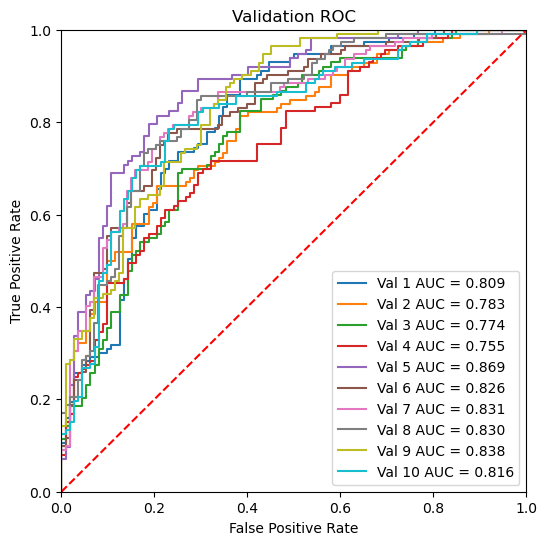

In [846]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

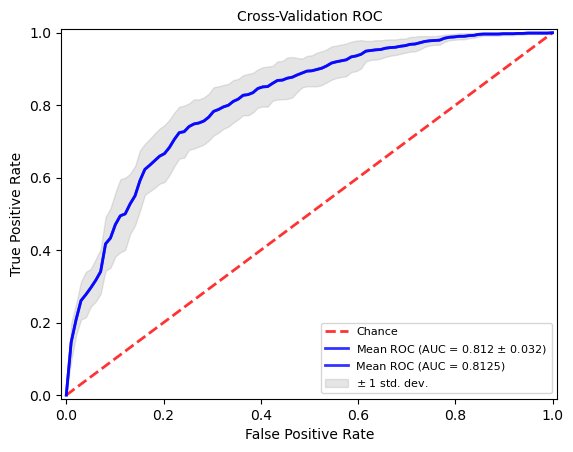

In [847]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [848]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [849]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [850]:
my_calculate_metrics_list_val

[{'SN': 0.7699115044247787,
  'SP': 0.6875,
  'ACC': 0.7288888888888889,
  'MCC': 0.4590466145124308,
  'Recall': 0.7699115044247787,
  'Precision': 0.7131147540983607,
  'F1-score': 0.7404255319148936,
  'Cutoff': 0.5},
 {'SN': 0.8214285714285714,
  'SP': 0.5714285714285714,
  'ACC': 0.6964285714285714,
  'MCC': 0.4057411124598246,
  'Recall': 0.8214285714285714,
  'Precision': 0.6571428571428571,
  'F1-score': 0.7301587301587301,
  'Cutoff': 0.5},
 {'SN': 0.8584070796460177,
  'SP': 0.5267857142857143,
  'ACC': 0.6933333333333334,
  'MCC': 0.40855461981284363,
  'Recall': 0.8584070796460177,
  'Precision': 0.6466666666666666,
  'F1-score': 0.7376425855513308,
  'Cutoff': 0.5},
 {'SN': 0.8053097345132744,
  'SP': 0.5178571428571429,
  'ACC': 0.6622222222222223,
  'MCC': 0.3375561930799648,
  'Recall': 0.8053097345132744,
  'Precision': 0.6275862068965518,
  'F1-score': 0.7054263565891473,
  'Cutoff': 0.5},
 {'SN': 0.8849557522123894,
  'SP': 0.7053571428571429,
  'ACC': 0.795555555555

In [851]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.769912,0.687500,0.728889,0.459047,0.769912,0.713115,0.740426,0.5
1,0.821429,0.571429,0.696429,0.405741,0.821429,0.657143,0.730159,0.5
2,0.858407,0.526786,0.693333,0.408555,0.858407,0.646667,0.737643,0.5
3,0.805310,0.517857,0.662222,0.337556,0.805310,0.627586,0.705426,0.5
4,0.884956,0.705357,0.795556,0.600359,0.884956,0.751880,0.813008,0.5
5,0.776786,0.752212,0.764444,0.529124,0.776786,0.756522,0.766520,0.5
6,0.776786,0.769912,0.773333,0.546697,0.776786,0.769912,0.773333,0.5
7,0.696429,0.831858,0.764444,0.533368,0.696429,0.804124,0.746411,0.5
8,0.750000,0.707965,0.728889,0.458327,0.750000,0.717949,0.733624,0.5
9,0.750000,0.776786,0.763393,0.526975,0.750000,0.770642,0.760181,0.5


In [852]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.769912,0.687500,0.728889,0.459047,0.769912,0.713115,0.740426,0.5
1,0.821429,0.571429,0.696429,0.405741,0.821429,0.657143,0.730159,0.5
2,0.858407,0.526786,0.693333,0.408555,0.858407,0.646667,0.737643,0.5
3,0.805310,0.517857,0.662222,0.337556,0.805310,0.627586,0.705426,0.5
4,0.884956,0.705357,0.795556,0.600359,0.884956,0.751880,0.813008,0.5
5,0.776786,0.752212,0.764444,0.529124,0.776786,0.756522,0.766520,0.5
6,0.776786,0.769912,0.773333,0.546697,0.776786,0.769912,0.773333,0.5
7,0.696429,0.831858,0.764444,0.533368,0.696429,0.804124,0.746411,0.5
8,0.750000,0.707965,0.728889,0.458327,0.750000,0.717949,0.733624,0.5
9,0.750000,0.776786,0.763393,0.526975,0.750000,0.770642,0.760181,0.5


In [853]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [854]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [855]:
roc_auc_list_indep

[0.8221460459183674,
 0.8089126275510203,
 0.79296875,
 0.8152901785714286,
 0.8268494897959183,
 0.8030931122448979,
 0.8177614795918366,
 0.8359375,
 0.8276466836734694,
 0.8142538265306123]

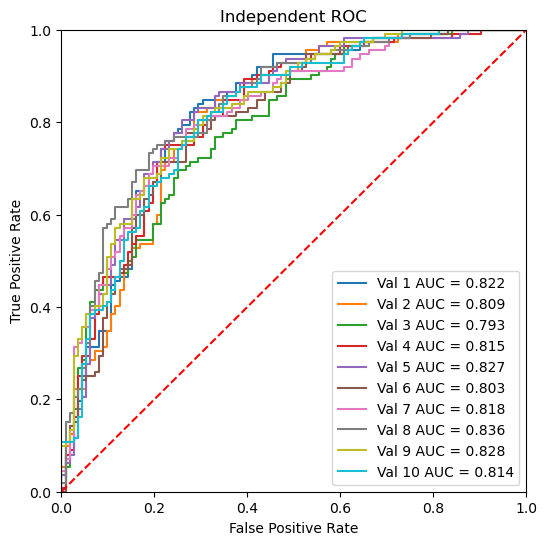

In [856]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

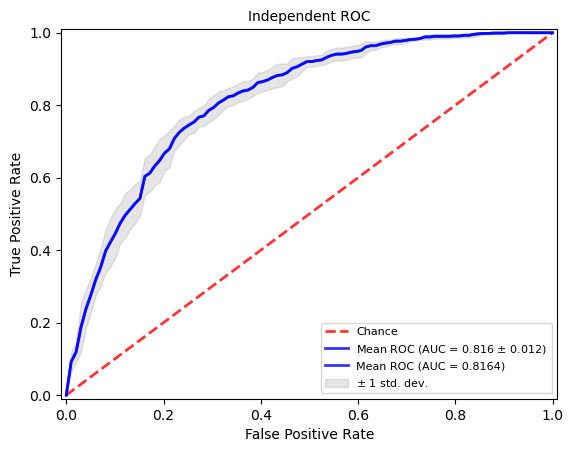

In [857]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [858]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [859]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [860]:
my_calculate_metrics_list_indep

[{'SN': 0.8035714285714286,
  'SP': 0.7232142857142857,
  'ACC': 0.7633928571428571,
  'MCC': 0.5284947946517572,
  'Recall': 0.8035714285714286,
  'Precision': 0.743801652892562,
  'F1-score': 0.7725321888412017,
  'Cutoff': 0.5},
 {'SN': 0.8482142857142857,
  'SP': 0.6517857142857143,
  'ACC': 0.75,
  'MCC': 0.5099344737276096,
  'Recall': 0.8482142857142857,
  'Precision': 0.7089552238805971,
  'F1-score': 0.7723577235772358,
  'Cutoff': 0.5},
 {'SN': 0.8571428571428571,
  'SP': 0.5178571428571429,
  'ACC': 0.6875,
  'MCC': 0.3986463582160496,
  'Recall': 0.8571428571428571,
  'Precision': 0.64,
  'F1-score': 0.732824427480916,
  'Cutoff': 0.5},
 {'SN': 0.8125,
  'SP': 0.6517857142857143,
  'ACC': 0.7321428571428571,
  'MCC': 0.470400463163761,
  'Recall': 0.8125,
  'Precision': 0.7,
  'F1-score': 0.7520661157024794,
  'Cutoff': 0.5},
 {'SN': 0.8303571428571429,
  'SP': 0.7053571428571429,
  'ACC': 0.7678571428571429,
  'MCC': 0.539949247156039,
  'Recall': 0.8303571428571429,
  'Pr

In [861]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.803571,0.723214,0.763393,0.528495,0.803571,0.743802,0.772532,0.5
1,0.848214,0.651786,0.750000,0.509934,0.848214,0.708955,0.772358,0.5
2,0.857143,0.517857,0.687500,0.398646,0.857143,0.640000,0.732824,0.5
3,0.812500,0.651786,0.732143,0.470400,0.812500,0.700000,0.752066,0.5
4,0.830357,0.705357,0.767857,0.539949,0.830357,0.738095,0.781513,0.5
5,0.732143,0.732143,0.732143,0.464286,0.732143,0.732143,0.732143,0.5
6,0.785714,0.714286,0.750000,0.501280,0.785714,0.733333,0.758621,0.5
7,0.723214,0.812500,0.767857,0.537862,0.723214,0.794118,0.757009,0.5
8,0.705357,0.785714,0.745536,0.492665,0.705357,0.766990,0.734884,0.5
9,0.678571,0.776786,0.727679,0.457569,0.678571,0.752475,0.713615,0.5


In [862]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.803571,0.723214,0.763393,0.528495,0.803571,0.743802,0.772532,0.5
1,0.848214,0.651786,0.750000,0.509934,0.848214,0.708955,0.772358,0.5
2,0.857143,0.517857,0.687500,0.398646,0.857143,0.640000,0.732824,0.5
3,0.812500,0.651786,0.732143,0.470400,0.812500,0.700000,0.752066,0.5
4,0.830357,0.705357,0.767857,0.539949,0.830357,0.738095,0.781513,0.5
5,0.732143,0.732143,0.732143,0.464286,0.732143,0.732143,0.732143,0.5
6,0.785714,0.714286,0.750000,0.501280,0.785714,0.733333,0.758621,0.5
7,0.723214,0.812500,0.767857,0.537862,0.723214,0.794118,0.757009,0.5
8,0.705357,0.785714,0.745536,0.492665,0.705357,0.766990,0.734884,0.5
9,0.678571,0.776786,0.727679,0.457569,0.678571,0.752475,0.713615,0.5


In [863]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_1\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [864]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

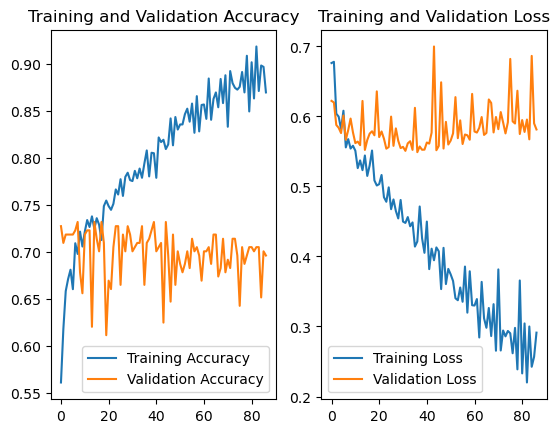

In [865]:

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()